# Demontration of neural network MCMC sampler trained with maximum Entropy objective 


## Please run Cells in the order provided.

Requirements: pytorch 1.6.0 (cuda not required), numpy, matplotlib

### First we import modules and setup the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from L2RW_models import L2GradRW, CovMALA
from L2RW import L2GradRW_M, adjust_lr
from distributions import distributions
from scipy.stats import entropy
from statsmodels.tsa.stattools import acf as autocorr
from tqdm import tqdm
from scipy.stats import multivariate_normal

In [2]:
def neff(arr):
    n = len(arr)
    acf = autocorr(arr, nlags=n, fft=True)
    sums = 0
    for k in range(1, len(acf)):
        sums = sums + (n-k)*acf[k]/n

    return n/(1+2*sums)

# Gravitational Wave Likelihood Model

In [3]:
# Define the waveform function h.
def h(t, phase, freq, dfreq, ddfreq):
    return torch.sin(phase + freq * t + dfreq * t**2 + ddfreq * t**3)

# Define the log likelihood function.
def log_likelihood(template, observed):
    # Calculate the difference and norm squared (waveform inner product)
    difference = observed - template
    norm_squared = np.linalg.norm(difference, axis=-1)**2
    return -0.5 * norm_squared  # log likelihood is -0.5 * ||difference||^2

# Define the time vector for the waveform.
t = torch.arange(0, 100, 0.1)  # From 0 to 100 in steps of 0.1

# Define a grid for phase and frequency.
phase_t = torch.arange(-torch.pi, torch.pi, 2 * torch.pi / 100)
freq_t  = torch.arange(0.8, 1.8, 1.0 / 100)

# Fixed parameters for generating the template waveform.
phase = 0
freq  = 1
dfreq = 0.1
ddfreq = 0.001

# Generate the template waveform (a 1D tensor over t).
template = torch.tensor([h(ti, phase, freq, dfreq, ddfreq) for ti in t])

# Generate the observed waveforms over the grid:
# For each frequency in freq_t and each phase in phase_t, compute a waveform over t.
observed = torch.tensor(np.array([[h(t, phasei, freqi, dfreq, ddfreq) for phasei in phase_t] for freqi in freq_t]))

# Compute the log likelihood for each grid point.
# loglike will have shape (len(freq_t), len(phase_t))
loglike = log_likelihood(template, observed)

# Optional: shift values so the minimum is zero (makes contour levels easier to display)
loglike = loglike - loglike.min()

# Prepare grid for plotting.
phase_t_np = phase_t.numpy()
freq_t_np  = freq_t.numpy()
X, Y = np.meshgrid(phase_t_np, freq_t_np)

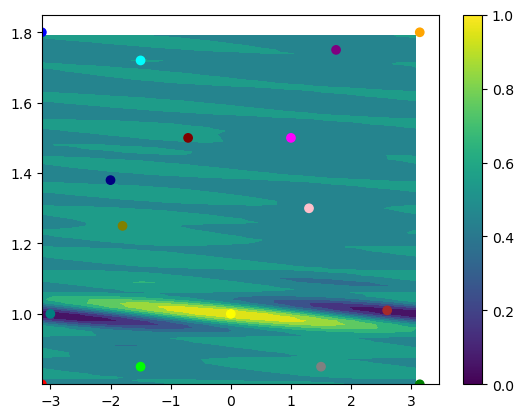

In [4]:
x0 = torch.tensor([-np.pi,-np.pi,np.pi,np.pi,1.75,-1.5,1,0,-1.5,-3,2.6,-2, 1.3,-1.8,-0.71,1.5])
y0 = torch.tensor([0.8,1.8,0.8,1.8,1.75,1.72,1.5,1,0.85,1,1.01,1.38,1.3,1.25,1.5,0.85])
colors = np.array(['red','blue','green','orange','purple','cyan','magenta','yellow','lime','teal','brown','navy','pink','olive','maroon','gray'])

plt.contourf(X,Y,loglike,9)
plt.scatter(x0,y0,c=colors)
plt.colorbar();
plt.show()

In [5]:
data_dim = 2
dim = 32
N_steps = 2
dist = distributions('toy',d=data_dim)
RW = L2GradRW(dist.Ex,data_dim,dim,N_steps,epsi=0.02,net_type='MLP',grad_mode='R',bias=True,act='elu') #diag_gaussian example use 0.001 epsi init
RW_controller = L2GradRW_M(RW,beta=1e-2,beta_max=1e3,rho_beta=0.1,adapt_beta=True,a_target=0.9,
                 lr=1e-3,momo=0.9,rms_momo=0.95,grad_norm=10,N_steps=10000)

### Train the Sampler

sldjxx is the proposal entropy (up to a constant equal to the entropy of Gaussian), it should increase during training

In [34]:
#train with real samples
bs = 512
for i in tqdm(range(5000)):
    x_init = dist.sample(bs)
    x, accept_rate, sldjxx, L2jump = RW_controller.sample_train(x_init,T=1,print_log= (True if i%100==0 else False))
    #adjust_lr(RW_controller,i,warmup=False,min_lr=1e-2)
    if i>5 and i%1000 == 0:
        print('1ksteps done, now {}'.format(i))

  0%|                                                                                 | 2/5000 [00:00<10:15,  8.12it/s]

jump 6.328e-01, Exp jump1.807e-03, accept 0.075,log_a -2.043e+03, sldjxx -7.824,beta 1.000e-02, epsi 2.002e-02


  2%|█▌                                                                             | 102/5000 [00:14<15:00,  5.44it/s]

jump 2.968e-01, Exp jump1.415e-02, accept 0.357,log_a -1.084e+02, sldjxx -7.099,beta 1.000e-02, epsi 1.996e-02


  4%|███▏                                                                           | 202/5000 [00:29<11:21,  7.04it/s]

jump 1.267e-01, Exp jump2.432e-02, accept 0.444,log_a -3.377e+01, sldjxx -6.895,beta 1.000e-02, epsi 1.973e-02


  6%|████▊                                                                          | 302/5000 [00:43<10:27,  7.48it/s]

jump 4.380e-02, Exp jump1.130e-02, accept 0.490,log_a -1.471e+01, sldjxx -7.231,beta 1.000e-02, epsi 1.961e-02


  8%|██████▎                                                                        | 402/5000 [00:56<09:29,  8.07it/s]

jump 3.140e-02, Exp jump1.017e-02, accept 0.501,log_a -5.478e+00, sldjxx -6.791,beta 1.000e-02, epsi 1.949e-02


 10%|███████▉                                                                       | 502/5000 [01:10<09:19,  8.03it/s]

jump 2.138e-02, Exp jump5.421e-03, accept 0.451,log_a -9.035e+00, sldjxx -7.092,beta 1.000e-02, epsi 1.934e-02


 12%|█████████▌                                                                     | 602/5000 [01:24<09:52,  7.42it/s]

jump 1.697e-02, Exp jump5.895e-03, accept 0.497,log_a -1.219e+00, sldjxx -6.732,beta 1.000e-02, epsi 1.915e-02


 14%|███████████                                                                    | 702/5000 [01:38<09:12,  7.78it/s]

jump 3.654e-02, Exp jump1.694e-02, accept 0.524,log_a -5.275e+00, sldjxx -5.899,beta 1.000e-02, epsi 1.917e-02


 16%|████████████▋                                                                  | 802/5000 [01:51<09:25,  7.43it/s]

jump 6.336e-02, Exp jump2.787e-02, accept 0.515,log_a 3.067e-01, sldjxx -5.920,beta 1.000e-02, epsi 1.926e-02


 18%|██████████████▎                                                                | 902/5000 [02:05<09:12,  7.42it/s]

jump 8.236e-02, Exp jump3.757e-02, accept 0.528,log_a -2.453e+00, sldjxx -5.787,beta 1.000e-02, epsi 1.936e-02


 20%|███████████████▋                                                              | 1002/5000 [02:20<09:34,  6.95it/s]

jump 8.155e-02, Exp jump4.073e-02, accept 0.525,log_a 2.296e+00, sldjxx -5.944,beta 1.000e-02, epsi 1.926e-02
1ksteps done, now 1000


 22%|█████████████████▏                                                            | 1102/5000 [02:34<08:52,  7.32it/s]

jump 5.699e-02, Exp jump2.110e-02, accept 0.503,log_a -6.192e+00, sldjxx -6.457,beta 1.000e-02, epsi 1.937e-02


 24%|██████████████████▊                                                           | 1202/5000 [02:48<08:29,  7.45it/s]

jump 4.951e-02, Exp jump1.860e-02, accept 0.473,log_a -4.420e+00, sldjxx -6.374,beta 1.000e-02, epsi 1.939e-02


 26%|████████████████████▎                                                         | 1302/5000 [03:01<08:04,  7.63it/s]

jump 5.436e-02, Exp jump1.873e-02, accept 0.476,log_a 1.109e+00, sldjxx -6.463,beta 1.000e-02, epsi 1.940e-02


 28%|█████████████████████▊                                                        | 1402/5000 [03:14<07:56,  7.55it/s]

jump 5.555e-02, Exp jump2.590e-02, accept 0.526,log_a 5.156e+00, sldjxx -6.320,beta 1.000e-02, epsi 1.943e-02


 30%|███████████████████████▍                                                      | 1502/5000 [03:28<07:57,  7.33it/s]

jump 8.391e-02, Exp jump3.888e-02, accept 0.520,log_a -6.234e-01, sldjxx -6.062,beta 1.000e-02, epsi 1.945e-02


 32%|████████████████████████▉                                                     | 1602/5000 [03:42<07:56,  7.13it/s]

jump 7.641e-02, Exp jump3.420e-02, accept 0.474,log_a -1.422e+00, sldjxx -6.113,beta 1.000e-02, epsi 1.944e-02


 34%|██████████████████████████▌                                                   | 1702/5000 [03:56<07:45,  7.08it/s]

jump 8.036e-02, Exp jump2.730e-02, accept 0.460,log_a -8.913e+00, sldjxx -6.202,beta 1.000e-02, epsi 1.947e-02


 36%|████████████████████████████                                                  | 1802/5000 [04:10<07:36,  7.01it/s]

jump 5.993e-02, Exp jump2.879e-02, accept 0.524,log_a 3.160e+00, sldjxx -6.012,beta 1.000e-02, epsi 1.936e-02


 38%|█████████████████████████████▋                                                | 1902/5000 [04:24<07:10,  7.19it/s]

jump 8.067e-02, Exp jump3.951e-02, accept 0.517,log_a 6.298e+00, sldjxx -5.925,beta 1.000e-02, epsi 1.938e-02


 40%|███████████████████████████████▏                                              | 2002/5000 [04:38<06:24,  7.80it/s]

jump 6.622e-02, Exp jump2.478e-02, accept 0.476,log_a -7.707e+00, sldjxx -6.076,beta 1.000e-02, epsi 1.937e-02
1ksteps done, now 2000


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4802/5000 [11:02<00:27,  7.27it/s]

jump 4.841e+00, Exp jump2.032e+00, accept 0.481,log_a 2.290e-01, sldjxx -2.561,beta 1.000e-02, epsi 1.959e-02


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4902/5000 [11:15<00:15,  6.46it/s]

jump 2.678e+00, Exp jump1.509e+00, accept 0.559,log_a 1.620e+00, sldjxx -2.827,beta 1.000e-02, epsi 1.959e-02


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:29<00:00,  7.25it/s]


### Sample continuously for 10000 steps

In [35]:
x = torch.tensor(np.array([x0,y0])).T
x_list = []
x_list.append(x)
for i in tqdm(range(10000)):
    x,xp,accept_vect,_ = RW_controller.sample(x,1,grad=False,print_log= True if i%1000==0 else False,)
    x_list.append(x.clone())

  0%|                                                                                | 8/10000 [00:00<03:19, 49.99it/s]

accept 0.375


 10%|███████▊                                                                     | 1007/10000 [00:15<02:18, 64.81it/s]

accept 0.0


 20%|███████████████▍                                                             | 2012/10000 [00:31<02:03, 64.57it/s]

accept 0.0


 30%|███████████████████████▏                                                     | 3009/10000 [00:47<01:52, 61.92it/s]

accept 0.0


 40%|██████████████████████████████▉                                              | 4012/10000 [01:04<01:25, 69.96it/s]

accept 0.0


 50%|██████████████████████████████████████▌                                      | 5008/10000 [01:20<01:31, 54.60it/s]

accept 0.0


 60%|██████████████████████████████████████████████▎                              | 6009/10000 [01:37<01:14, 53.71it/s]

accept 0.0


 70%|██████████████████████████████████████████████████████                       | 7013/10000 [01:53<00:47, 63.23it/s]

accept 0.0


 80%|█████████████████████████████████████████████████████████████▋               | 8007/10000 [02:08<00:29, 67.11it/s]

accept 0.0


 90%|█████████████████████████████████████████████████████████████████████▍       | 9010/10000 [02:23<00:14, 67.39it/s]

accept 0.0


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:38<00:00, 63.11it/s]


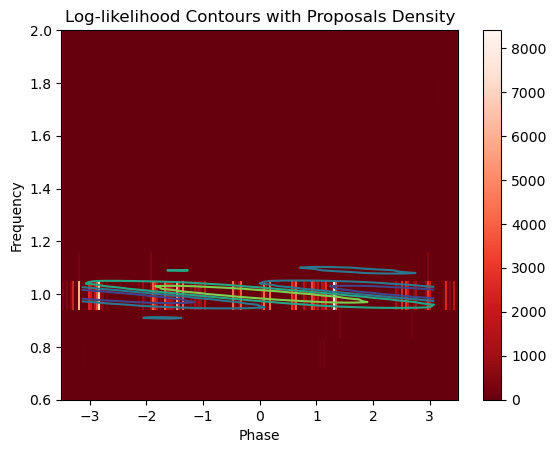

In [44]:
x_try = np.array(x_list)
plt.contour(X, Y, loglike, levels=5, cmap='viridis')
plt.hist2d(x_try[:,:,0].flatten(),x_try[:,:,1].flatten(), bins=(200,200), cmap=plt.cm.Reds_r)
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Log-likelihood Contours with Proposals Density')
plt.colorbar()
plt.xlim([-3.5, 3.5])
plt.ylim([0.6, 2])
plt.show()

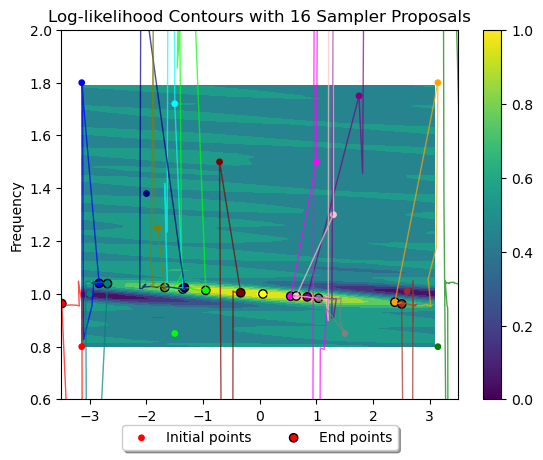

In [45]:
xp_np = np.array(x_list)  # shape (10001, 16, 2)

plt.contourf(X, Y, loglike, 10)
plt.scatter(x0, y0, color=colors,s=15, marker='o', label='Initial points')
plt.scatter(xp_np[10000,:,0], xp_np[10000,:,1], color=colors, edgecolors='k',marker='o', label='End points')

# Overlay trajectories
for i in range(xp_np.shape[1]):
    plt.plot(xp_np[:, i, 0], xp_np[:, i, 1], color=colors[i], alpha=0.7, linewidth=1)
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Log-likelihood Contours with 16 Sampler Proposals')
plt.xlim([-3.5, 3.5])
plt.ylim([0.6, 2])
plt.colorbar();
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

### Visualize distribution in the batch at the last time point

Should see fair samples from the toy distribution

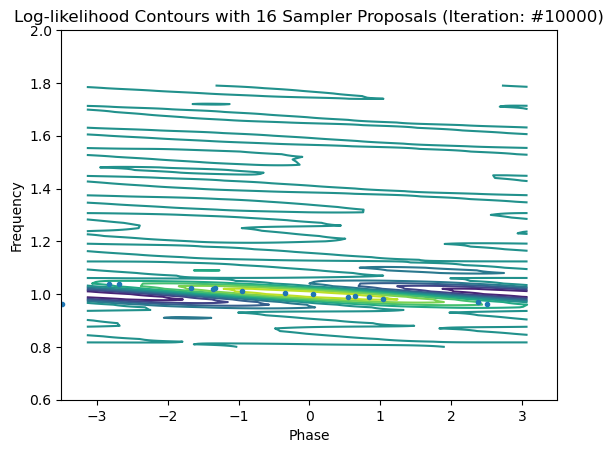

In [46]:
xp_np = x_list[-1].detach().cpu().numpy()
plt.contour(X, Y, loglike, levels=10, cmap='viridis')
plt.plot(xp_np[:,0],xp_np[:,1],'.')
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Log-likelihood Contours with 16 Sampler Proposals (Iteration: #10000)')
plt.xlim([-3.5, 3.5])
plt.ylim([0.6, 2])
plt.show()

### Visualize the evolution of first dimension (horizontal axis), 

Should be a Gaussian with little correlation.

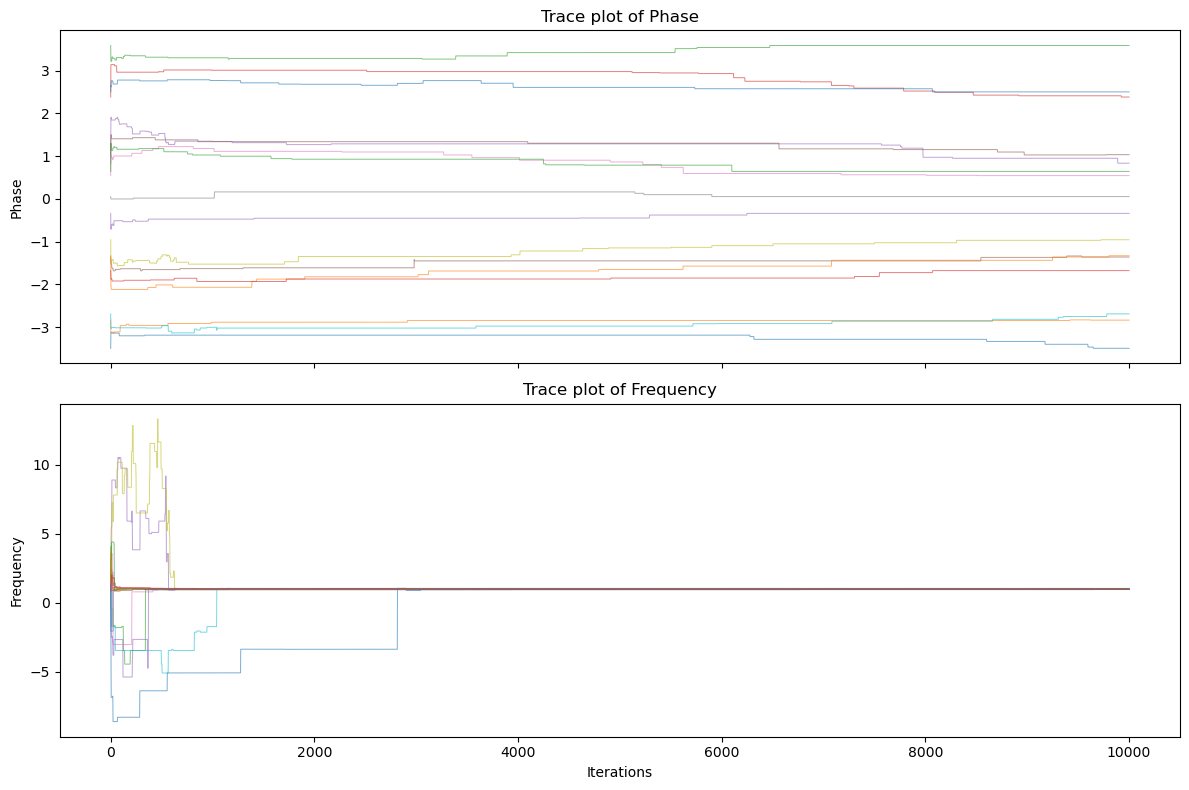

In [39]:
xp_np = np.array(x_list)
iterations = xp_np.shape[0]

param_names = ['Phase', 'Frequency']

fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# Loop over each parameter (e.g., Phase and Frequency)
for param_idx in range(2):
    ax = axes[param_idx]
    for chain_idx in range(xp_np.shape[1]):
        ax.plot(
            np.arange(iterations),
            xp_np[:,chain_idx, param_idx],
            alpha=0.6,
            linewidth=0.7
        )
    ax.set_ylabel(f'{param_names[param_idx]}')
    ax.set_title(f'Trace plot of {param_names[param_idx]}')

axes[-1].set_xlabel('Iterations')

plt.tight_layout()
plt.show()

y mean 0.6073760390281677, y std 1.3100464344024658


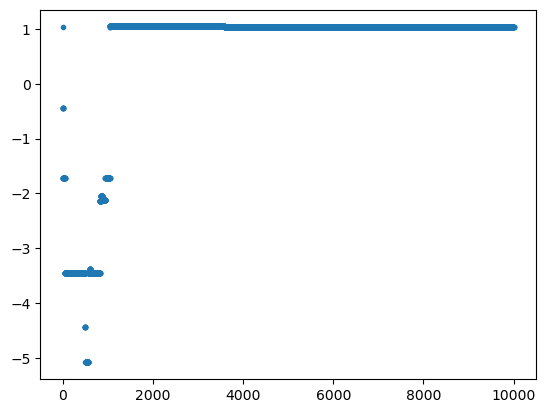

In [40]:
batch_i = 9
visualize_dim = 1 #change to 1 for the vertical axis
y_vect = torch.stack(x_list,dim=0)[0:,batch_i,visualize_dim].detach().cpu().numpy()
fig, ax = plt.subplots()
ax.plot(y_vect,'.')
y_mean, y_std = y_vect.mean(), y_vect.std()
print('y mean {}, y std {}'.format(y_mean.item(), y_std.item()))

In [41]:
# Define bin edges for histogramming
x_edges = np.linspace(-np.pi, np.pi, 101)
y_edges = np.linspace(0.8, 1.8, 101)
hist_0 = loglike

kl_divergence = []
ess = []
for i in range(len(x0)):
    # Compute histogram of post-burnin samples for KL divergence
    chain_array = np.array(x_list)  # shape: (chainlen-burnin+1, 2)
    hist_A, _, _ = np.histogram2d(chain_array[5000:,i,0], chain_array[5000:,i,1],
                                  bins=[x_edges, y_edges], density=True)
    prob_A = hist_A / np.sum(hist_A)
    prob_0 = hist_0 / np.sum(hist_0)
    prob_A_flat = prob_A.flatten() + 1e-10
    prob_0_flat = prob_0.flatten() + 1e-10
    kl_div = entropy(prob_A_flat, prob_0_flat)
    kl_divergence.append(kl_div)

    ess0 = np.array([neff(chain_array[5000:,i,k]) for k in range(2)])
    ess.append(ess0)

In [42]:
kl_divergence, ess

([nan,
  9.083384189920547,
  nan,
  7.047108349407302,
  8.283467773065327,
  8.371428521772396,
  8.136842808006092,
  8.621882245864326,
  7.899798897066478,
  7.683015285174076,
  8.52895158680894,
  7.724387484852084,
  8.671929836399356,
  7.93682495679094,
  8.952846596137494,
  7.9974178840862855],
 [array([6.32013868, 8.24053279]),
  array([16.49409579, 14.52955241]),
  array([ 8.71862373, 18.56454455]),
  array([5.11097682, 6.1264592 ]),
  array([5.83697268, 5.91539896]),
  array([ 7.2388663 , 51.82908062]),
  array([ 9.18527316, 55.2365647 ]),
  array([11.5777232 , 11.01263763]),
  array([ 5.22881054, 39.72933609]),
  array([ 5.80461921, 69.90193046]),
  array([ 5.81775898, 13.63992028]),
  array([5.65080371, 6.77944147]),
  array([8.74822532, 8.74822532]),
  array([5.51720452, 8.58843712]),
  array([9.93468377, 8.25511126]),
  array([5.49662391, 7.17954152])])

In [43]:
np.nanmean(kl_divergence), np.nanmean(ess,axis=0), np.mean(np.array(accept_vect.float()))

(8.209949029667975, array([ 7.66758752, 20.89229465]), 0.0)

# Gaussian Mixture Model Distribution

In [5]:
# This chunk is to initial mus, covs and pis of GMM
mu_1 = torch.tensor([-5., 5.])
mu_2 = torch.tensor([5., -5.])
mu_3 = torch.tensor([5.,5.])
mu_4 = torch.tensor([-5.,-5.])
mus = torch.tensor(np.array([mu_1,mu_2,mu_3,mu_4]), dtype=torch.float32)

cov_1 = 0.9 * torch.eye(2)
cov_2 = 1.2 * torch.eye(2)
cov_3 = 0.04 * torch.tensor([[5,-4],[-4,5]])
cov_4 = 0.08* torch.tensor([[5,4],[4,5]])
covs = torch.tensor(np.array([cov_1, cov_2, cov_3, cov_4]),dtype=torch.float32)

pis = torch.tensor(np.array([0.25, 0.25, 0.25, 0.25]), dtype=torch.float32)

In [6]:
def plot_gaussian_contours(mus, covs, colors=['blue', 'red'], spacing=5,
        x_lims=[-4,4], y_lims=[-3,3], res=100):

    X = np.linspace(x_lims[0], x_lims[1], res)
    Y = np.linspace(y_lims[0], y_lims[1], res)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    for i in range(len(mus)):
        mu = mus[i]
        cov = covs[i]
        F = multivariate_normal(mu, cov)
        Z = F.pdf(pos)
        plt.contour(X, Y, Z, spacing, colors=colors[0])

    return plt

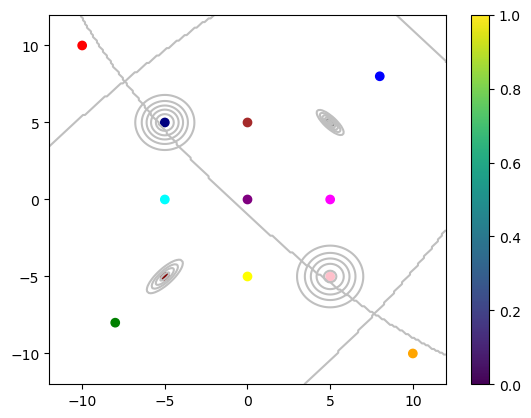

In [7]:
x0 = torch.tensor([-10.,8.,-8.,10.,0.,-5.,5.,0.,0.,-5.,5.,-5.,5.])
y0 = torch.tensor([10.,8.,-8.,-10.,0.,0.,0.,-5.,5.,5.,-5.,-5.,5.])
colors = np.array(['red','blue','green','orange','purple','cyan','magenta','yellow','brown','navy','pink','maroon','gray'])

plot_gaussian_contours(mus, covs, colors=['0.75','0.75'], x_lims=[-12,12], y_lims=[-12,12], res=200)
plt.scatter(x0,y0,c=colors)
plt.colorbar();
plt.show()

In [103]:
data_dim = 2
dim = 32
N_steps = 2
dist = distributions('GMM',d=data_dim,mus=mus, covs=covs,pis=pis)
RW2 = L2GradRW(dist.Ex,data_dim,dim,N_steps,epsi=0.01,net_type='MLP',grad_mode='R',bias=True,act='elu') #diag_gaussian example use 0.001 epsi init
RW_controller2 = L2GradRW_M(RW2,beta=1e-2,beta_max=1e3,rho_beta=0.1,adapt_beta=True,a_target=0.9,
                 lr=1e-3,momo=0.9,rms_momo=0.95,grad_norm=10,N_steps=10000)

In [104]:
#train with real samples
bs = 512
for i in tqdm(range(5000)):
    x_init = dist.sample(bs)
    x, accept_rate, sldjxx, L2jump = RW_controller2.sample_train(x_init,T=1,print_log= (True if i%100==0 else False))
    #adjust_lr(RW_controller,i,warmup=False,min_lr=1e-2)
    if i>5 and i%1000 == 0:
        print('1ksteps done, now {}'.format(i))

  0%|                                                                                 | 2/5000 [00:00<08:23,  9.93it/s]

jump 9.789e-05, Exp jump9.789e-05, accept 1.000,log_a 1.576e-06, sldjxx -9.210,beta 1.010e-02, epsi 1.001e-02


  2%|█▌                                                                             | 102/5000 [00:09<07:51, 10.39it/s]

jump 5.204e-03, Exp jump5.201e-03, accept 0.998,log_a 3.290e-04, sldjxx -5.205,beta 2.669e-02, epsi 1.111e-02


  4%|███▏                                                                           | 202/5000 [00:19<07:27, 10.72it/s]

jump 8.446e-02, Exp jump8.298e-02, accept 0.976,log_a -5.560e-03, sldjxx -2.661,beta 6.568e-02, epsi 1.219e-02


  6%|████▊                                                                          | 302/5000 [00:29<07:57,  9.85it/s]

jump 1.657e-01, Exp jump1.588e-01, accept 0.976,log_a -6.906e-04, sldjxx -2.104,beta 1.420e-01, epsi 1.259e-02


  8%|██████▎                                                                        | 403/5000 [00:39<07:00, 10.94it/s]

jump 2.315e-01, Exp jump2.072e-01, accept 0.947,log_a -3.570e-02, sldjxx -1.825,beta 2.653e-01, epsi 1.272e-02


 10%|███████▉                                                                       | 502/5000 [00:50<08:28,  8.85it/s]

jump 3.898e-01, Exp jump3.462e-01, accept 0.933,log_a -2.980e-02, sldjxx -1.490,beta 3.874e-01, epsi 1.287e-02


 12%|█████████▌                                                                     | 602/5000 [01:01<08:04,  9.09it/s]

jump 6.315e-01, Exp jump5.545e-01, accept 0.924,log_a -3.908e-02, sldjxx -1.130,beta 4.580e-01, epsi 1.315e-02


 14%|███████████                                                                    | 702/5000 [01:13<08:23,  8.53it/s]

jump 8.496e-01, Exp jump7.558e-01, accept 0.914,log_a -4.867e-02, sldjxx -0.932,beta 4.942e-01, epsi 1.337e-02


 16%|████████████▋                                                                  | 802/5000 [01:26<08:13,  8.50it/s]

jump 1.034e+00, Exp jump8.452e-01, accept 0.909,log_a -5.291e-02, sldjxx -0.911,beta 5.134e-01, epsi 1.347e-02


 18%|██████████████▎                                                                | 902/5000 [01:38<07:57,  8.58it/s]

jump 1.341e+00, Exp jump1.235e+00, accept 0.915,log_a -1.224e-02, sldjxx -0.779,beta 5.623e-01, epsi 1.360e-02


 20%|███████████████▋                                                              | 1002/5000 [01:50<07:48,  8.53it/s]

jump 1.288e+00, Exp jump1.111e+00, accept 0.914,log_a -4.191e-02, sldjxx -0.752,beta 5.927e-01, epsi 1.366e-02
1ksteps done, now 1000


 22%|█████████████████▏                                                            | 1102/5000 [02:01<07:17,  8.91it/s]

jump 1.382e+00, Exp jump1.228e+00, accept 0.919,log_a -1.343e-02, sldjxx -0.728,beta 6.163e-01, epsi 1.370e-02


 24%|██████████████████▊                                                           | 1202/5000 [02:13<07:21,  8.60it/s]

jump 1.299e+00, Exp jump1.176e+00, accept 0.898,log_a -5.749e-02, sldjxx -0.709,beta 6.533e-01, epsi 1.373e-02


 26%|████████████████████▎                                                         | 1302/5000 [02:24<07:16,  8.47it/s]

jump 1.327e+00, Exp jump1.134e+00, accept 0.896,log_a -5.027e-02, sldjxx -0.705,beta 6.462e-01, epsi 1.375e-02


 28%|█████████████████████▊                                                        | 1402/5000 [02:36<06:41,  8.96it/s]

jump 1.542e+00, Exp jump1.347e+00, accept 0.882,log_a -7.458e-02, sldjxx -0.693,beta 6.591e-01, epsi 1.378e-02


 30%|███████████████████████▍                                                      | 1502/5000 [02:47<06:34,  8.87it/s]

jump 1.403e+00, Exp jump1.141e+00, accept 0.884,log_a -7.506e-02, sldjxx -0.678,beta 6.507e-01, epsi 1.379e-02


 32%|████████████████████████▉                                                     | 1602/5000 [02:59<06:20,  8.94it/s]

jump 1.579e+00, Exp jump1.376e+00, accept 0.893,log_a -4.204e-02, sldjxx -0.675,beta 6.593e-01, epsi 1.381e-02


 34%|██████████████████████████▌                                                   | 1702/5000 [03:10<06:07,  8.97it/s]

jump 1.446e+00, Exp jump1.251e+00, accept 0.905,log_a -4.177e-02, sldjxx -0.695,beta 6.657e-01, epsi 1.381e-02


 36%|████████████████████████████                                                  | 1802/5000 [03:21<05:58,  8.92it/s]

jump 1.369e+00, Exp jump1.241e+00, accept 0.909,log_a -4.026e-02, sldjxx -0.715,beta 6.637e-01, epsi 1.383e-02


 38%|█████████████████████████████▋                                                | 1902/5000 [03:32<05:45,  8.97it/s]

jump 1.374e+00, Exp jump1.201e+00, accept 0.917,log_a -2.440e-02, sldjxx -0.706,beta 6.850e-01, epsi 1.385e-02


 40%|███████████████████████████████▏                                              | 2002/5000 [03:44<05:29,  9.11it/s]

jump 1.648e+00, Exp jump1.272e+00, accept 0.865,log_a -1.086e-01, sldjxx -0.636,beta 6.757e-01, epsi 1.386e-02
1ksteps done, now 2000


 42%|████████████████████████████████▊                                             | 2102/5000 [03:55<05:36,  8.62it/s]

jump 1.574e+00, Exp jump1.239e+00, accept 0.887,log_a -7.363e-02, sldjxx -0.680,beta 6.813e-01, epsi 1.389e-02


 44%|██████████████████████████████████▎                                           | 2202/5000 [04:06<05:23,  8.65it/s]

jump 1.321e+00, Exp jump1.183e+00, accept 0.905,log_a -4.563e-02, sldjxx -0.693,beta 6.793e-01, epsi 1.388e-02


 46%|███████████████████████████████████▉                                          | 2302/5000 [04:17<05:00,  8.97it/s]

jump 1.410e+00, Exp jump1.181e+00, accept 0.882,log_a -7.058e-02, sldjxx -0.651,beta 6.929e-01, epsi 1.390e-02


 48%|█████████████████████████████████████▍                                        | 2402/5000 [04:29<04:53,  8.85it/s]

jump 1.400e+00, Exp jump1.157e+00, accept 0.912,log_a -3.597e-02, sldjxx -0.707,beta 6.826e-01, epsi 1.391e-02


 50%|███████████████████████████████████████                                       | 2502/5000 [04:40<04:40,  8.89it/s]

jump 1.578e+00, Exp jump1.333e+00, accept 0.877,log_a -8.419e-02, sldjxx -0.652,beta 6.834e-01, epsi 1.393e-02


 52%|████████████████████████████████████████▌                                     | 2602/5000 [04:51<04:31,  8.83it/s]

jump 1.518e+00, Exp jump1.403e+00, accept 0.937,log_a -1.803e-02, sldjxx -0.765,beta 6.749e-01, epsi 1.392e-02


 54%|██████████████████████████████████████████▏                                   | 2702/5000 [05:03<04:16,  8.96it/s]

jump 1.422e+00, Exp jump1.180e+00, accept 0.880,log_a -7.068e-02, sldjxx -0.653,beta 6.821e-01, epsi 1.396e-02


 56%|███████████████████████████████████████████▋                                  | 2802/5000 [05:14<04:05,  8.94it/s]

jump 1.466e+00, Exp jump1.205e+00, accept 0.881,log_a -6.893e-02, sldjxx -0.655,beta 6.870e-01, epsi 1.397e-02


 58%|█████████████████████████████████████████████▎                                | 2902/5000 [05:25<03:55,  8.92it/s]

jump 1.325e+00, Exp jump1.246e+00, accept 0.927,log_a -2.650e-02, sldjxx -0.719,beta 6.807e-01, epsi 1.397e-02


 60%|██████████████████████████████████████████████▊                               | 3002/5000 [05:37<03:50,  8.65it/s]

jump 1.365e+00, Exp jump1.155e+00, accept 0.907,log_a -4.376e-02, sldjxx -0.675,beta 6.811e-01, epsi 1.399e-02
1ksteps done, now 3000


 62%|████████████████████████████████████████████████▍                             | 3102/5000 [05:48<03:39,  8.65it/s]

jump 1.397e+00, Exp jump1.185e+00, accept 0.901,log_a -5.176e-02, sldjxx -0.683,beta 6.865e-01, epsi 1.400e-02


 64%|█████████████████████████████████████████████████▉                            | 3202/5000 [05:59<03:17,  9.09it/s]

jump 1.440e+00, Exp jump1.224e+00, accept 0.900,log_a -3.613e-02, sldjxx -0.665,beta 6.976e-01, epsi 1.402e-02


 66%|███████████████████████████████████████████████████▌                          | 3302/5000 [06:10<03:11,  8.88it/s]

jump 1.490e+00, Exp jump1.240e+00, accept 0.888,log_a -6.609e-02, sldjxx -0.654,beta 6.957e-01, epsi 1.404e-02


 68%|█████████████████████████████████████████████████████                         | 3402/5000 [06:22<03:00,  8.88it/s]

jump 1.435e+00, Exp jump1.261e+00, accept 0.902,log_a -5.010e-02, sldjxx -0.687,beta 6.932e-01, epsi 1.404e-02


 70%|██████████████████████████████████████████████████████▋                       | 3502/5000 [06:33<02:47,  8.96it/s]

jump 1.320e+00, Exp jump1.148e+00, accept 0.919,log_a -2.636e-02, sldjxx -0.706,beta 6.718e-01, epsi 1.405e-02


 72%|████████████████████████████████████████████████████████▏                     | 3602/5000 [06:45<03:07,  7.46it/s]

jump 1.550e+00, Exp jump1.353e+00, accept 0.907,log_a -4.814e-02, sldjxx -0.696,beta 6.843e-01, epsi 1.407e-02


 74%|█████████████████████████████████████████████████████████▊                    | 3702/5000 [06:58<02:37,  8.25it/s]

jump 1.505e+00, Exp jump1.268e+00, accept 0.897,log_a -4.759e-02, sldjxx -0.682,beta 6.934e-01, epsi 1.407e-02


 76%|███████████████████████████████████████████████████████████▎                  | 3802/5000 [07:09<02:15,  8.85it/s]

jump 1.460e+00, Exp jump1.268e+00, accept 0.904,log_a -4.845e-02, sldjxx -0.670,beta 6.906e-01, epsi 1.408e-02


 78%|████████████████████████████████████████████████████████████▊                 | 3902/5000 [07:22<02:13,  8.23it/s]

jump 1.386e+00, Exp jump1.129e+00, accept 0.910,log_a -4.253e-02, sldjxx -0.700,beta 6.993e-01, epsi 1.409e-02


 80%|██████████████████████████████████████████████████████████████▍               | 4002/5000 [07:34<01:56,  8.57it/s]

jump 1.387e+00, Exp jump1.254e+00, accept 0.901,log_a -4.450e-02, sldjxx -0.674,beta 6.898e-01, epsi 1.412e-02
1ksteps done, now 4000


 82%|███████████████████████████████████████████████████████████████▉              | 4102/5000 [07:46<01:48,  8.27it/s]

jump 1.229e+00, Exp jump1.074e+00, accept 0.912,log_a -4.607e-02, sldjxx -0.707,beta 6.933e-01, epsi 1.411e-02


 84%|█████████████████████████████████████████████████████████████████▌            | 4202/5000 [07:58<01:31,  8.75it/s]

jump 1.498e+00, Exp jump1.293e+00, accept 0.904,log_a -5.201e-02, sldjxx -0.689,beta 7.011e-01, epsi 1.413e-02


 86%|███████████████████████████████████████████████████████████████████           | 4302/5000 [08:10<01:19,  8.77it/s]

jump 1.405e+00, Exp jump1.181e+00, accept 0.897,log_a -4.181e-02, sldjxx -0.662,beta 6.934e-01, epsi 1.414e-02


 88%|████████████████████████████████████████████████████████████████████▋         | 4402/5000 [08:21<01:09,  8.56it/s]

jump 1.492e+00, Exp jump1.218e+00, accept 0.894,log_a -5.441e-02, sldjxx -0.666,beta 6.953e-01, epsi 1.415e-02


 90%|██████████████████████████████████████████████████████████████████████▏       | 4502/5000 [08:33<00:57,  8.67it/s]

jump 1.412e+00, Exp jump1.235e+00, accept 0.902,log_a -3.944e-02, sldjxx -0.654,beta 6.907e-01, epsi 1.415e-02


 92%|███████████████████████████████████████████████████████████████████████▊      | 4602/5000 [08:44<00:45,  8.69it/s]

jump 1.529e+00, Exp jump1.368e+00, accept 0.905,log_a -3.151e-02, sldjxx -0.682,beta 7.030e-01, epsi 1.415e-02


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4702/5000 [08:56<00:34,  8.65it/s]

jump 1.455e+00, Exp jump1.256e+00, accept 0.887,log_a -5.409e-02, sldjxx -0.636,beta 6.950e-01, epsi 1.417e-02


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4802/5000 [09:08<00:22,  8.75it/s]

jump 1.602e+00, Exp jump1.338e+00, accept 0.907,log_a -4.310e-02, sldjxx -0.675,beta 6.922e-01, epsi 1.418e-02


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4902/5000 [09:19<00:11,  8.88it/s]

jump 1.482e+00, Exp jump1.257e+00, accept 0.914,log_a -3.625e-02, sldjxx -0.690,beta 7.038e-01, epsi 1.419e-02


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [09:30<00:00,  8.76it/s]


In [105]:
x = torch.tensor(np.array([x0,y0])).T
#bs = 10
#x = dist.sample(bs)

x_list2 = []
x_list2.append(x.clone())
for i in tqdm(range(10000)):
    x,xp,accept_vect,_ = RW_controller2.sample(x,1,grad=False,print_log= True if i%1000==0 else False,)
    x_list2.append(x.clone())

  0%|                                                                                | 6/10000 [00:00<06:11, 26.93it/s]

accept 0.9230769276618958


 10%|███████▋                                                                     | 1005/10000 [00:32<04:48, 31.23it/s]

accept 0.9230769276618958


 20%|███████████████▍                                                             | 2006/10000 [01:04<04:30, 29.57it/s]

accept 0.8461538553237915


 30%|███████████████████████▏                                                     | 3004/10000 [01:36<03:49, 30.52it/s]

accept 1.0


 40%|██████████████████████████████▊                                              | 4004/10000 [02:09<03:42, 26.91it/s]

accept 1.0


 50%|██████████████████████████████████████▌                                      | 5005/10000 [02:40<02:30, 33.28it/s]

accept 0.8461538553237915


 60%|██████████████████████████████████████████████▏                              | 6005/10000 [03:12<02:19, 28.62it/s]

accept 0.9230769276618958


 70%|█████████████████████████████████████████████████████▉                       | 7006/10000 [03:44<01:31, 32.59it/s]

accept 1.0


 80%|█████████████████████████████████████████████████████████████▋               | 8005/10000 [04:16<01:09, 28.71it/s]

accept 0.9230769276618958


 90%|█████████████████████████████████████████████████████████████████████▎       | 9005/10000 [04:47<00:32, 30.95it/s]

accept 1.0


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:19<00:00, 31.32it/s]


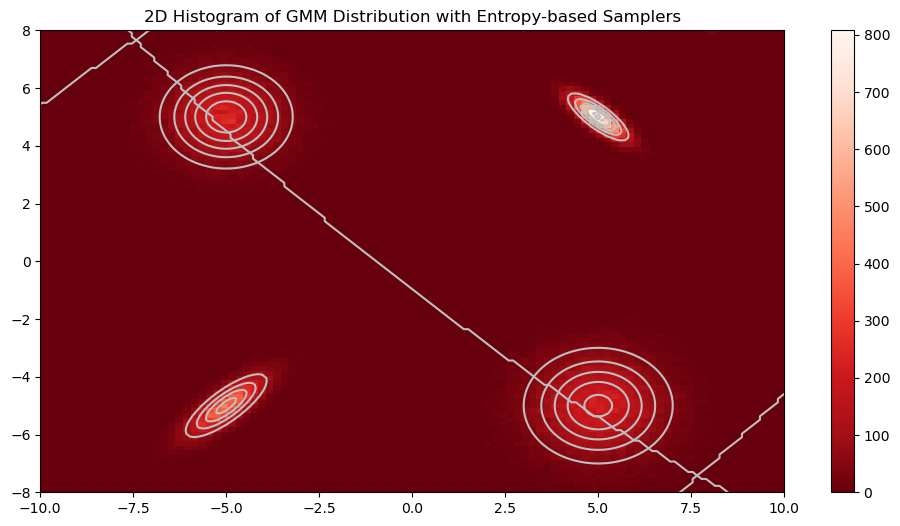

In [106]:
c_contour = '0.75'
theory = dist.sample(10000)
x_try2 = np.array(x_list2)
plt.figure(figsize=(12, 6))
x_edges = np.linspace(-10,10,int(np.sqrt(10000)))
y_edges = np.linspace(-8,8,int(np.sqrt(10000)))

plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-12,12], y_lims=[-12,12], res=200)
plt.hist2d(x_try2[:,:,0].flatten(), x_try2[:,:,1].flatten(), bins=[x_edges, y_edges], cmap=plt.cm.Reds_r)
plt.colorbar()
plt.title('2D Histogram of GMM Distribution with Entropy-based Samplers')
plt.show()

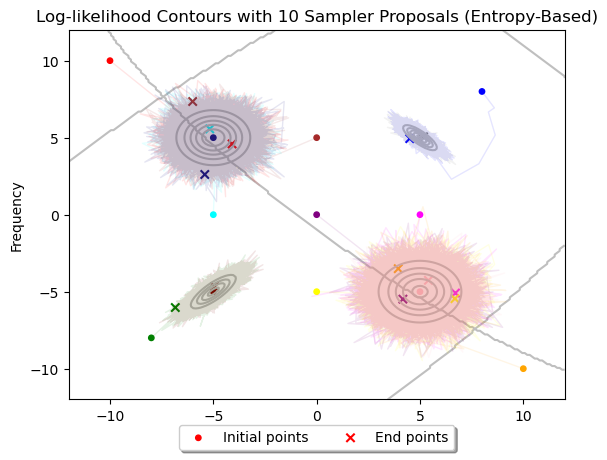

In [118]:
c_true, c_contour = 'purple', '0.75'
xp_np2 = np.array(x_list2)
plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-12,12], y_lims=[-12,12], res=200)
plt.scatter(x0, y0, color=colors,s=15, marker='o', label='Initial points')
plt.scatter(xp_np2[10000,:,0], xp_np2[10000,:,1], color=colors, marker='x', label='End points')

# Overlay trajectories
for i in range(xp_np2.shape[1]):
    plt.plot(xp_np2[:, i, 0], xp_np2[:, i, 1], color=colors[i], alpha=0.1, linewidth=1)

plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Log-likelihood Contours with 10 Sampler Proposals (Entropy-Based)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [114]:
np.array(x_list2).shape

(10001, 13, 2)

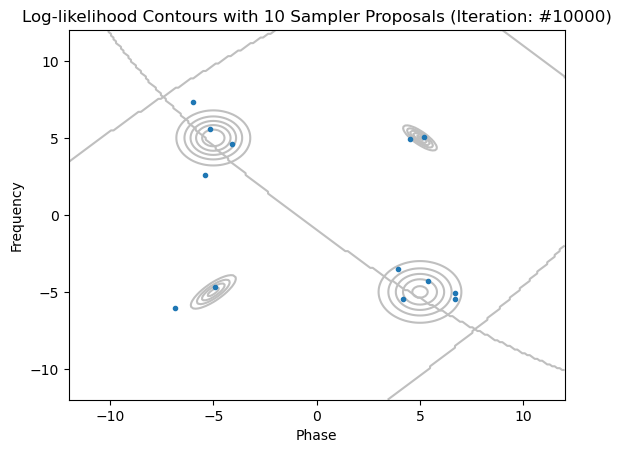

In [117]:
xp_np2 = x_list2[-1].detach().cpu().numpy()
plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-12,12], y_lims=[-12,12], res=200)
plt.plot(xp_np2[:,0],xp_np2[:,1],'.')
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Log-likelihood Contours with 10 Sampler Proposals (Iteration: #10000)')
plt.show()

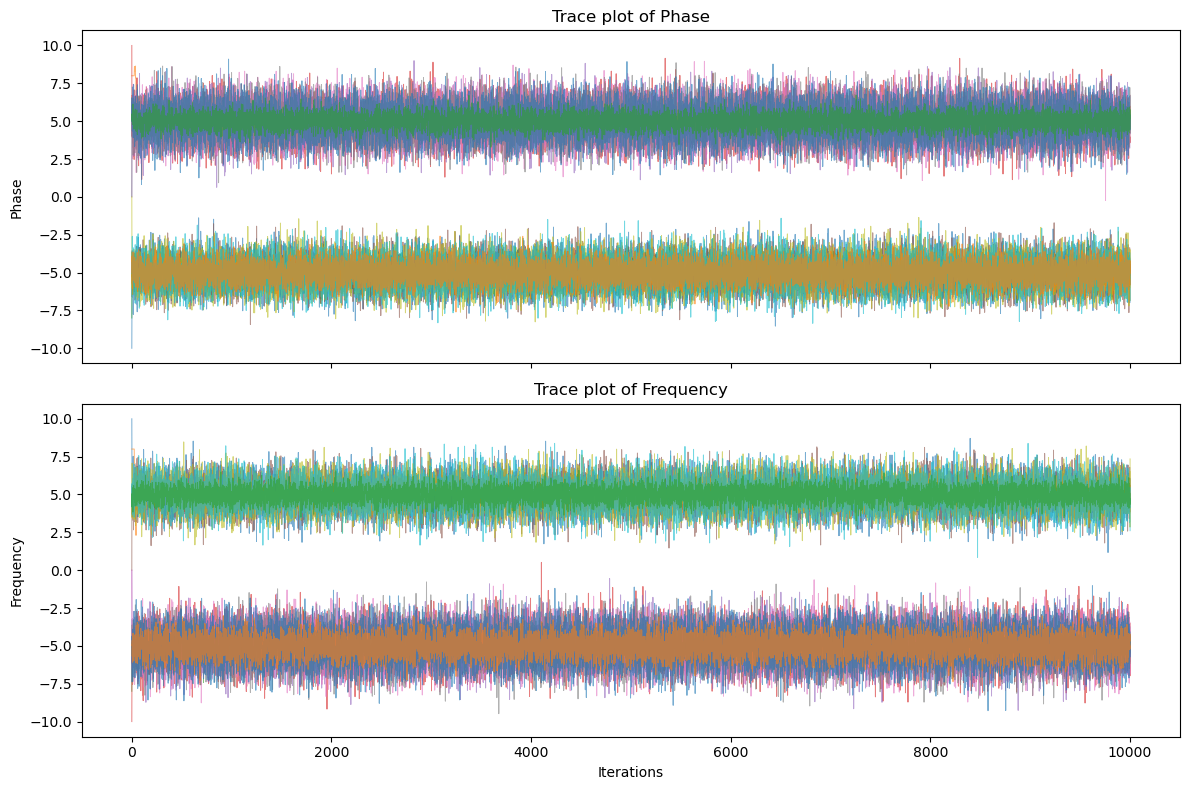

In [109]:
xp_np2 = np.array(x_list2)
iterations = xp_np2.shape[0]

param_names = ['Phase', 'Frequency']

fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# Loop over each parameter (e.g., Phase and Frequency)
for param_idx in range(2):
    ax = axes[param_idx]
    for chain_idx in range(xp_np2.shape[1]):
        ax.plot(
            np.arange(iterations),
            xp_np2[:,chain_idx, param_idx],
            alpha=0.6,
            linewidth=0.7
        )
    ax.set_ylabel(f'{param_names[param_idx]}')
    ax.set_title(f'Trace plot of {param_names[param_idx]}')

axes[-1].set_xlabel('Iterations')

plt.tight_layout()
plt.show()

In [110]:
# Define bin edges for histogramming
hist_0, _, _ = np.histogram2d(theory[:, 0], theory[:, 1], bins=[x_edges, y_edges], density=True)

kl_divergence2 = []
ess2 = []
for i in range(len(colors)):
    # Compute histogram of post-burnin samples for KL divergence
    chain_array = np.array(x_list2)  # shape: (chainlen-burnin+1, 2)
    hist_A, _, _ = np.histogram2d(chain_array[5000:,i,0], chain_array[5000:,i,1],
                                  bins=[x_edges, y_edges], density=True)
    prob_A = hist_A / np.sum(hist_A)
    prob_0 = hist_0 / np.sum(hist_0)
    prob_A_flat = prob_A.flatten() + 1e-10
    prob_0_flat = prob_0.flatten() + 1e-10
    kl_div = entropy(prob_A_flat, prob_0_flat)
    kl_divergence2.append(kl_div)

    ess0 = np.array([neff(chain_array[5000:,i,k]) for k in range(2)])
    ess2.append(ess0)

In [111]:
kl_divergence2, ess2

([2.472530981581709,
  1.5258754940680574,
  1.6672597921009584,
  2.7897123169564324,
  2.7883004861563494,
  2.347466402945003,
  2.716254040202181,
  2.6636009498876994,
  2.379280875147444,
  2.3815291503122324,
  2.8115143313331865,
  1.6191811142901837,
  1.5564582651497938],
 [array([14673.43951926,  5799.49077151]),
  array([12213.27602098, 13816.3896428 ]),
  array([ 8715.28015831, 24165.32418365]),
  array([20975.45413607,  5562.42247074]),
  array([32955.41339142, 15843.90738209]),
  array([34384.00514617, 31904.9078936 ]),
  array([ 1986.78330635, 54892.57139847]),
  array([55004.69303918, 11872.81841192]),
  array([ 5300.92788924, 18436.38428108]),
  array([8569.96639129, 5736.74260593]),
  array([19481.76086547,  5866.80896433]),
  array([37029.1580051, 39947.9874886]),
  array([40453.85379286, 44745.63274543])])

In [112]:
np.nanmean(kl_divergence2), np.nanmean(ess2,axis=0), np.mean(np.array(accept_vect.float()))

(2.286074169240864, array([22441.8470509, 21430.1067877]), 1.0)

# Moon Distribution

In [28]:
x0 = torch.tensor([-0.2763, -0.5227, 0.2667, 1.1608, -0.0107, -0.5375, -0.1518, -0.4553, -0.2056, 2.0992])
y0 = torch.tensor([0.9025, -0.8384, -0.4792, -0.3755, -0.5761, 1.2326, 1.1072, 1.2231, 0.4552, 0.6527])
colors = np.array(['red','blue','green','orange','purple','yellow','brown','navy','pink','gray'])


In [ ]:
Z0 = torch.tensor(np.array([x0,y0])).T

In [38]:
# For moon contour plot later on
x_edges = np.linspace(-4,4,int(np.sqrt(10000)))
y_edges = np.linspace(-7,5,int(np.sqrt(10000)))
X, Y = np.meshgrid(x_edges, y_edges)

grid_points = np.vstack([X.ravel(), Y.ravel()]).T
grid_tensor = torch.from_numpy(grid_points.astype(np.float32))
with torch.no_grad():
    Z = npdensity(grid_tensor).numpy().reshape(X.shape)

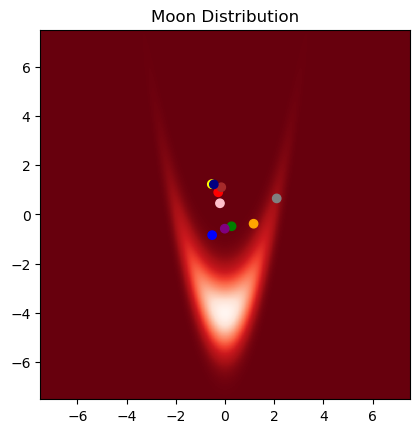

In [39]:
def npdensity(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    E_y = z1**2/2
    E_x = (z2 - z1**2 + 4)**2/2
    return np.exp(-(E_y+E_x))

r = np.linspace(-7.5, 7.5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap=plt.cm.Reds_r)
plt.scatter(Z0[:,0],Z0[:,1], color=colors)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Moon Distribution')
plt.show()

In [110]:
data_dim = 2
dim = 32
N_steps = 2
dist = distributions('moon',d=data_dim)
RW = L2GradRW(dist.Ex,data_dim,dim,N_steps,epsi=5,net_type='MLP',grad_mode='R',bias=True,act='elu') #diag_gaussian example use 0.001 epsi init
RW_controller3 = L2GradRW_M(RW,beta=1e-2,beta_max=1e3,rho_beta=0.1,adapt_beta=True,a_target=0.9,
                 lr=1e-3,momo=0.9,rms_momo=0.95,grad_norm=10,N_steps=10000)

In [111]:
#train with real samples
bs = 512
for i in tqdm(range(5000)):
    x_init = dist.sample(bs)
    x, accept_rate, sldjxx, L2jump = RW_controller3.sample_train(x_init,T=1,print_log= (True if i%100==0 else False))
    #adjust_lr(RW_controller,i,warmup=False,min_lr=1e-2)
    if i>5 and i%1000 == 0:
        print('1ksteps done, now {}'.format(i))

  0%|                                                                                 | 3/5000 [00:00<06:37, 12.57it/s]

jump 5.464e+02, Exp jump1.445e-02, accept 0.006,log_a -2.081e+12, sldjxx 3.219,beta 1.000e-02, epsi 4.995e+00


  2%|█▋                                                                             | 103/5000 [00:05<04:10, 19.51it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


  4%|███▏                                                                           | 205/5000 [00:10<03:58, 20.12it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


  6%|████▊                                                                          | 303/5000 [00:15<03:56, 19.85it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


  8%|██████▎                                                                        | 403/5000 [00:21<04:02, 18.97it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 10%|███████▉                                                                       | 503/5000 [00:26<03:50, 19.53it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 12%|█████████▌                                                                     | 605/5000 [00:31<03:47, 19.35it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 14%|███████████                                                                    | 703/5000 [00:36<03:41, 19.44it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 16%|████████████▋                                                                  | 803/5000 [00:41<03:38, 19.20it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 18%|██████████████▎                                                                | 904/5000 [00:47<03:27, 19.74it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 20%|███████████████▋                                                              | 1003/5000 [00:52<03:25, 19.43it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan
1ksteps done, now 1000


 22%|█████████████████▏                                                            | 1104/5000 [00:57<03:21, 19.36it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 24%|██████████████████▊                                                           | 1204/5000 [01:02<03:14, 19.47it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 26%|████████████████████▎                                                         | 1304/5000 [01:07<03:13, 19.11it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 28%|█████████████████████▉                                                        | 1404/5000 [01:12<03:03, 19.58it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 30%|███████████████████████▍                                                      | 1504/5000 [01:18<03:02, 19.18it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 32%|█████████████████████████                                                     | 1604/5000 [01:23<02:55, 19.33it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 34%|██████████████████████████▌                                                   | 1704/5000 [01:28<02:52, 19.08it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 36%|████████████████████████████▏                                                 | 1803/5000 [01:33<02:46, 19.18it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 38%|█████████████████████████████▋                                                | 1903/5000 [01:38<02:42, 19.11it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 40%|███████████████████████████████▏                                              | 2003/5000 [01:44<02:36, 19.18it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan
1ksteps done, now 2000


 42%|████████████████████████████████▊                                             | 2103/5000 [01:49<03:18, 14.58it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 44%|██████████████████████████████████▍                                           | 2205/5000 [01:54<02:25, 19.19it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 46%|███████████████████████████████████▉                                          | 2303/5000 [02:00<02:21, 19.10it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 48%|█████████████████████████████████████▍                                        | 2403/5000 [02:05<02:15, 19.14it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 50%|███████████████████████████████████████                                       | 2503/5000 [02:10<02:11, 18.97it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 52%|████████████████████████████████████████▌                                     | 2603/5000 [02:15<02:05, 19.05it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 54%|██████████████████████████████████████████▏                                   | 2703/5000 [02:21<02:03, 18.54it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 56%|███████████████████████████████████████████▋                                  | 2803/5000 [02:26<01:56, 18.88it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 58%|█████████████████████████████████████████████▎                                | 2903/5000 [02:31<01:51, 18.88it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 60%|██████████████████████████████████████████████▉                               | 3005/5000 [02:37<01:45, 18.94it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan
1ksteps done, now 3000


 62%|████████████████████████████████████████████████▍                             | 3103/5000 [02:42<01:39, 19.03it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 64%|█████████████████████████████████████████████████▉                            | 3205/5000 [02:48<01:35, 18.78it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 66%|███████████████████████████████████████████████████▌                          | 3305/5000 [02:53<01:29, 19.04it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 68%|█████████████████████████████████████████████████████                         | 3405/5000 [02:58<01:23, 19.15it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 70%|██████████████████████████████████████████████████████▋                       | 3505/5000 [03:03<01:19, 18.88it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 72%|████████████████████████████████████████████████████████▏                     | 3605/5000 [03:09<01:13, 18.96it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 74%|█████████████████████████████████████████████████████████▊                    | 3705/5000 [03:14<01:07, 19.04it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 76%|███████████████████████████████████████████████████████████▎                  | 3803/5000 [03:19<01:03, 18.90it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 78%|████████████████████████████████████████████████████████████▉                 | 3903/5000 [03:25<00:58, 18.88it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 80%|██████████████████████████████████████████████████████████████▍               | 4003/5000 [03:30<00:53, 18.69it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan
1ksteps done, now 4000


 82%|████████████████████████████████████████████████████████████████              | 4103/5000 [03:35<00:47, 18.96it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 84%|█████████████████████████████████████████████████████████████████▌            | 4203/5000 [03:41<00:42, 18.70it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 86%|███████████████████████████████████████████████████████████████████▏          | 4303/5000 [03:46<00:37, 18.72it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 88%|████████████████████████████████████████████████████████████████████▋         | 4403/5000 [03:51<00:32, 18.41it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 90%|██████████████████████████████████████████████████████████████████████▏       | 4503/5000 [03:57<00:26, 18.81it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 92%|███████████████████████████████████████████████████████████████████████▊      | 4603/5000 [04:02<00:21, 18.43it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4703/5000 [04:07<00:15, 18.90it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4803/5000 [04:13<00:10, 18.70it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4905/5000 [04:18<00:05, 18.75it/s]

jump nan, Exp jumpnan, accept nan,log_a nan, sldjxx nan,beta nan, epsi nan


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:23<00:00, 18.96it/s]


In [112]:
#bs = 1024
x = Z0
x_list3 = []
for i in tqdm(range(10000)):
    x,xp,accept_vect,_ = RW_controller3.sample(x,1,grad=False,print_log= True if i%1000==0 else False,)
    x_list3.append(x.clone())

  0%|▏                                                                              | 20/10000 [00:00<01:42, 97.46it/s]

accept 0.0


 10%|███████▋                                                                    | 1013/10000 [00:09<01:24, 106.62it/s]

accept 0.0


 20%|███████████████▎                                                            | 2018/10000 [00:18<01:13, 108.82it/s]

accept 0.0


 30%|██████████████████████▉                                                     | 3023/10000 [00:27<01:04, 108.66it/s]

accept 0.0


 40%|██████████████████████████████▌                                             | 4021/10000 [00:37<00:54, 109.01it/s]

accept 0.0


 50%|██████████████████████████████████████                                      | 5014/10000 [00:46<00:45, 109.30it/s]

accept 0.0


 60%|█████████████████████████████████████████████▋                              | 6016/10000 [00:55<00:36, 109.94it/s]

accept 0.0


 70%|█████████████████████████████████████████████████████▎                      | 7014/10000 [01:04<00:27, 108.39it/s]

accept 0.0


 80%|████████████████████████████████████████████████████████████▉               | 8015/10000 [01:14<00:17, 111.29it/s]

accept 0.0


 90%|████████████████████████████████████████████████████████████████████▌       | 9018/10000 [01:23<00:09, 108.41it/s]

accept 0.0


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:32<00:00, 108.28it/s]


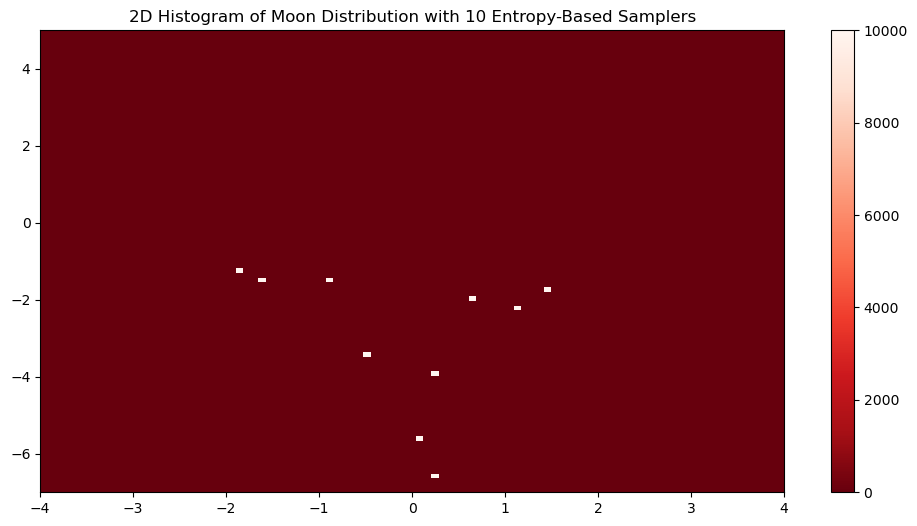

In [113]:
c_contour = '0.75'
theory = dist.sample(10000)
x_try3 = np.array(x_list3)
plt.figure(figsize=(12, 6))
x_edges = np.linspace(-4,4,int(np.sqrt(10000)))
y_edges = np.linspace(-7,5,int(np.sqrt(10000)))

#plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-12,12], y_lims=[-12,12], res=200)
plt.hist2d(x_try3[:,:,0].flatten(), x_try3[:,:,1].flatten(), bins=[x_edges, y_edges], cmap=plt.cm.Reds_r)
plt.colorbar()
plt.title('2D Histogram of Moon Distribution with 10 Entropy-Based Samplers')
plt.show()

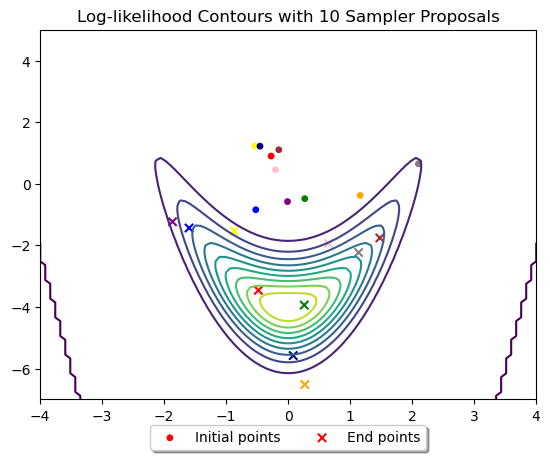

In [114]:
c_true, c_contour = 'purple', '0.75'
xp_np3 = np.array(x_list3)
plt.contour(X,Y,Z, levels=10)
plt.scatter(x0, y0, color=colors,s=15, marker='o', label='Initial points')
plt.scatter(xp_np3[9999,:,0], xp_np3[9999,:,1], color=colors,marker='x', label='End points')

# Overlay trajectories
for i in range(xp_np3.shape[1]):
    plt.plot(xp_np3[:, i, 0], xp_np3[:, i, 1], color=colors[i], alpha=0.1, linewidth=1)


plt.title('Log-likelihood Contours with 10 Sampler Proposals')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

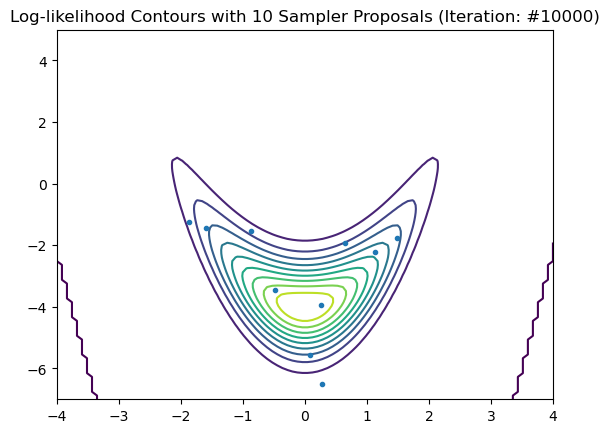

In [115]:
xp_np3 = x_list3[-1].detach().cpu().numpy()
plt.contour(X,Y,Z, levels=10)
plt.plot(xp_np3[:,0],xp_np3[:,1],'.')

plt.title('Log-likelihood Contours with 10 Sampler Proposals (Iteration: #10000)')
plt.show()

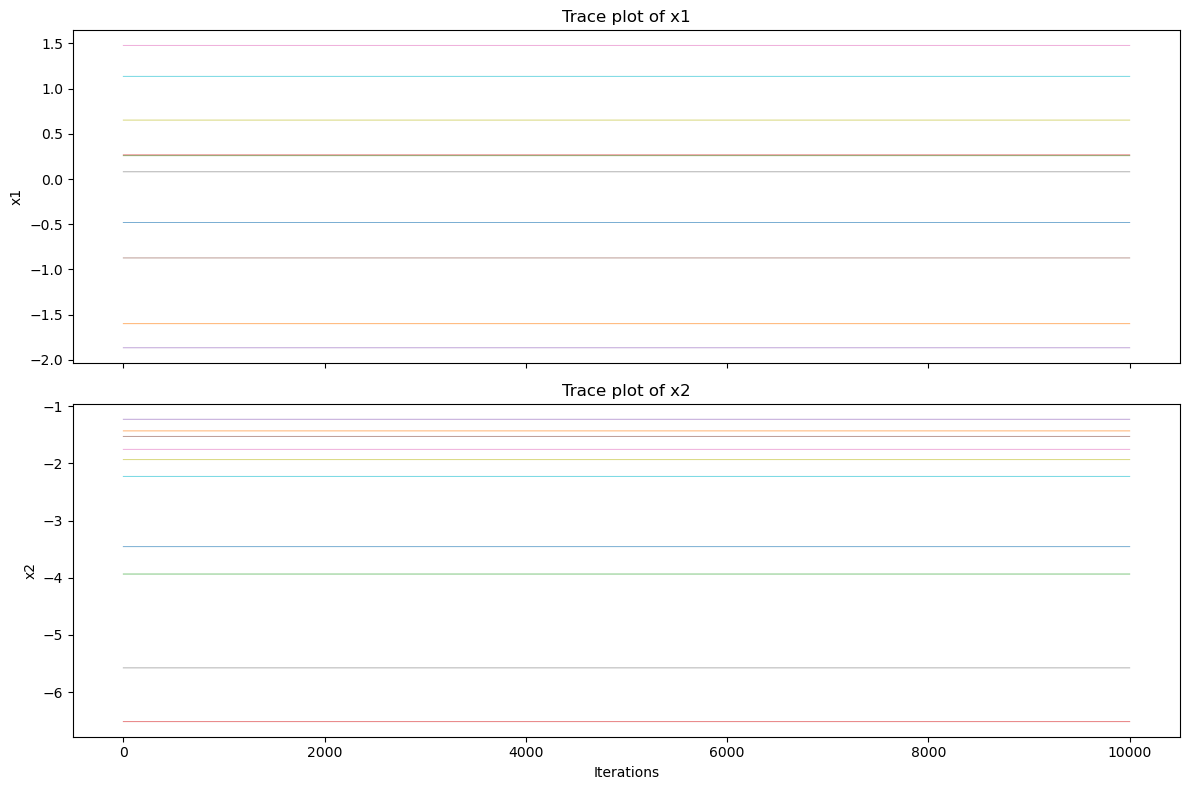

In [116]:
xp_np3 = np.array(x_list3)
iterations = xp_np3.shape[0]

param_names = ['x1','x2']

fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# Loop over each parameter (e.g., Phase and Frequency)
for param_idx in range(2):
    ax = axes[param_idx]
    for chain_idx in range(xp_np3.shape[1]):
        ax.plot(
            np.arange(iterations),
            xp_np3[:,chain_idx, param_idx],
            alpha=0.6,
            linewidth=0.7
        )
    ax.set_ylabel(f'{param_names[param_idx]}')
    ax.set_title(f'Trace plot of {param_names[param_idx]}')

axes[-1].set_xlabel('Iterations')

plt.tight_layout()
plt.show()

In [117]:
# Define bin edges for histogramming
hist_0, _, _ = np.histogram2d(theory[:, 0], theory[:, 1], bins=[x_edges, y_edges], density=True)

kl_divergence3 = []
ess3 = []
for i in range(len(colors)):
    # Compute histogram of post-burnin samples for KL divergence
    chain_array = np.array(x_list3)  # shape: (chainlen-burnin+1, 2)
    hist_A, _, _ = np.histogram2d(chain_array[:,i,0], chain_array[:,i,1],
                                  bins=[x_edges, y_edges], density=True)
    prob_A = hist_A / np.sum(hist_A)
    prob_0 = hist_0 / np.sum(hist_0)
    prob_A_flat = prob_A.flatten() + 1e-10
    prob_0_flat = prob_0.flatten() + 1e-10
    kl_div = entropy(prob_A_flat, prob_0_flat)
    kl_divergence3.append(kl_div)

    ess1 = np.array([neff(chain_array[:,i,k]) for k in range(2)])
    ess3.append(ess1)

C:\Users\justi\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [118]:
kl_divergence3, ess3

([6.640971580554519,
  8.10730695691064,
  6.210189113476565,
  23.025825222258586,
  8.512771501689741,
  8.512771501689743,
  7.819625249382356,
  7.5964819665508605,
  8.107306956910636,
  7.819625249382337],
 [array([nan, nan]),
  array([nan, nan]),
  array([nan, nan]),
  array([nan, nan]),
  array([nan, nan]),
  array([nan, nan]),
  array([nan, nan]),
  array([nan, nan]),
  array([nan, nan]),
  array([nan, nan])])

In [119]:
np.nanmean(kl_divergence3), np.nanmean(ess3,axis=0), np.mean(np.array(accept_vect.float()))

C:\Users\justi\AppData\Local\Temp\ipykernel_16944\1830463330.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(kl_divergence3), np.nanmean(ess3,axis=0), np.mean(np.array(accept_vect.float()))


(9.235287529880598, array([nan, nan]), 0.0)